In [ ]:
# Install dependency packages
!pip install -q grad-cam seaborn pandas numpy scikit-learn matplotlib pillow

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Create dataset directory --- Run only once
DRIVE_FOOD101_DIR = "/content/drive/MyDrive/datasets/food-101"
# !mkdir -p {DRIVE_FOOD101_DIR}

# Download and extract to Drive --- Run only once
# !wget -q https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz -O /content/food-101.tar.gz
# !tar -xf /content/food-101.tar.gz -C {DRIVE_FOOD101_DIR} --strip-components=1

# Verify
print("Food-101 directory structure in Drive:")
!ls {DRIVE_FOOD101_DIR}
print("\nVerify images directory:")
!ls {DRIVE_FOOD101_DIR}/images | head -3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Food-101 directory structure in Drive:
images	license_agreement.txt  meta  README.txt

Verify images directory:
apple_pie
baby_back_ribs
baklava


In [ ]:
# Basic configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4

# Point to the dataset path in Drive
FOOD101_ROOT = "/content/drive/MyDrive/datasets/food-101"
ATTRIBUTE_SHEET_PATH = "/content/culinary_attributes.json"
SUBSET_CLASSES = 40

# Verify if the Drive path is correct
print("Does the Drive dataset path exist:", os.path.exists(FOOD101_ROOT))
!ls {FOOD101_ROOT}/images

Does the Drive dataset path exist: True
apple_pie	    eggs_benedict	     onion_rings
baby_back_ribs	    escargots		     oysters
baklava		    falafel		     pad_thai
beef_carpaccio	    filet_mignon	     pancakes
beef_tartare	    fish_and_chips	     panna_cotta
beet_salad	    foie_gras		     peking_duck
beignets	    french_fries	     pho
bibimbap	    french_onion_soup	     pizza
bread_pudding	    french_toast	     pork_chop
breakfast_burrito   fried_calamari	     poutine
bruschetta	    fried_rice		     prime_rib
caesar_salad	    frozen_yogurt	     pulled_pork_sandwich
caprese_salad	    garlic_bread	     ramen
carrot_cake	    gnocchi		     ravioli
ceviche		    greek_salad		     red_velvet_cake
cheesecake	    grilled_cheese_sandwich  risotto
cheese_plate	    guacamole		     samosa
chicken_curry	    gyoza		     sashimi
chicken_quesadilla  hamburger		     scallops
chicken_wings	    hot_and_sour_soup	     seaweed_salad
chocolate_cake	    hot_dog		     shrimp_and_grits
chocolate_mousse    huevo

In [ ]:
# -------------------------- Data Preprocessing --------------------------
train_transform = transforms.Compose([
    transforms.Resize(256),  # Replace RandomResizedCrop to avoid random cropping of irrelevant regions
    transforms.CenterCrop(224),  # Consistent with validation set: fixed center cropping (retains core features)
    transforms.RandomHorizontalFlip(p=0.5),  # Keep mild augmentation (random horizontal flip) to prevent overfitting
    # Temporarily comment out ColorJitter to reduce color disturbance
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------------- Custom Dataset Class --------------------------
class Food101SubsetDataset(Dataset):
    def __init__(self, root, class_names, transform=None, split="train"):
        self.root = root
        self.class_names = class_names
        self.class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Adapt to official filenames
        split_filename = "train.txt" if split == "train" else "test.txt"
        split_file = os.path.join(root, "meta", split_filename) # Ensure split_file is correctly defined

        # Load split file
        with open(split_file, "r") as f:
            lines = f.readlines()
            # Pre-filter: Select target classes first to reduce subsequent IO
            for line in lines:
                dish_path = line.strip()
                dish_class = dish_path.split("/")[0]
                if dish_class in self.class_names:
                    full_img_path = os.path.join(root, "images", f"{dish_path}.jpg")
                    self.image_paths.append(full_img_path)
                    self.labels.append(self.class_to_idx[dish_class])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # Drive image read error tolerance
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"⚠️ Failed to read image {img_path}, using blank image instead: {e}")
            image = Image.new("RGB", (224, 224), color="white")

        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, img_path

# -------------------------- Build Dataset --------------------------
# Load all classes and randomly select 40
all_classes = [d for d in os.listdir(os.path.join(FOOD101_ROOT, "images"))
               if os.path.isdir(os.path.join(FOOD101_ROOT, "images", d))]
subset_class_names = np.random.choice(all_classes, size=SUBSET_CLASSES, replace=False).tolist()

# Initialize training/validation datasets
train_dataset = Food101SubsetDataset(FOOD101_ROOT, subset_class_names, train_transform, split="train")
val_dataset = Food101SubsetDataset(FOOD101_ROOT, subset_class_names, val_transform, split="val")

# Build DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,  # Key: Do not set >2 for Drive to prevent lag
    pin_memory=True  # Improve GPU transfer speed
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Verify dataset loading
print(f"\n=== Dataset Loading Completed ===")
print(f"Training set samples: {len(train_dataset)}")
print(f"Validation set samples: {len(val_dataset)}")
print(f"Sample image path: {train_dataset.image_paths[0]}")


=== Dataset Loading Completed ===
Training set samples: 30000
Validation set samples: 10000
Sample image path: /content/drive/MyDrive/datasets/food-101/images/baby_back_ribs/1005293.jpg


In [ ]:
# -------------------------- Culinary Attribute Sheet --------------------------
# Path to the existing attribute sheet in Drive
ATTRIBUTE_SHEET_PATH = "/content/drive/MyDrive/datasets/food-101/culinary_attributes.json"

# Verify if the file exists
if not os.path.exists(ATTRIBUTE_SHEET_PATH):
    raise FileNotFoundError(f"Attribute sheet file not found! Please check the path: {ATTRIBUTE_SHEET_PATH}")

# Load the pre-prepared attribute sheet directly
with open(ATTRIBUTE_SHEET_PATH, "r") as f:
    ATTRIBUTE_SHEET = json.load(f)

# -------------------------- Define ResNet50 Model --------------------------
def build_model(num_classes):
    # Load pre-trained model
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    # Fine-tune entire network
    for param in model.parameters():
        param.requires_grad = True
    # Replace the last layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Initialize model
model = build_model(num_classes=SUBSET_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Verify model structure
print("Model structure (last three layers):")
print(list(model.children())[-3:])

Model structure (last three layers):
[Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
# -------------------------- Model Training --------------------------
from tqdm import tqdm  # Pre-installed in Colab for progress bar display

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")

    # Training phase
    model.train()
    train_loss, train_correct = 0.0, 0
    pbar = tqdm(train_loader, desc="Training")  # Progress bar
    for images, labels, _ in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({"loss": loss.item()})
    pbar.close()

    # Validation phase
    model.eval()
    val_loss, val_correct = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validation")
        for images, labels, _ in pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix({"val_loss": loss.item()})
        pbar.close()

    # Calculate metrics
    train_loss = train_loss / len(train_dataset)
    train_acc = train_correct / len(train_dataset) * 100
    val_loss = val_loss / len(val_dataset)
    val_acc = val_correct / len(val_dataset) * 100

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.1f}%")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.1f}%")

# Save model to Colab
torch.save(model.state_dict(), "/content/foodvision_plus_model.pth")
print("Model saved to /content/foodvision_plus_model.pth")


===== Epoch 1/10 =====


Validation: 100%|██████████| 313/313 [01:27<00:00,  3.56it/s, val_loss=0.41]


Training Loss: 1.0849 | Training Accuracy: 71.0%
Validation Loss: 0.5328 | Validation Accuracy: 84.9%

===== Epoch 2/10 =====


Validation: 100%|██████████| 313/313 [01:26<00:00,  3.63it/s, val_loss=0.566]


Training Loss: 0.5885 | Training Accuracy: 83.3%
Validation Loss: 0.4840 | Validation Accuracy: 85.9%

===== Epoch 3/10 =====


Validation: 100%|██████████| 313/313 [01:26<00:00,  3.64it/s, val_loss=0.684]


Training Loss: 0.4227 | Training Accuracy: 87.9%
Validation Loss: 0.4756 | Validation Accuracy: 86.5%

===== Epoch 4/10 =====


Validation: 100%|██████████| 313/313 [01:26<00:00,  3.64it/s, val_loss=0.601]


Training Loss: 0.3171 | Training Accuracy: 90.9%
Validation Loss: 0.4838 | Validation Accuracy: 86.2%

===== Epoch 5/10 =====


Validation: 100%|██████████| 313/313 [01:27<00:00,  3.57it/s, val_loss=0.29]


Training Loss: 0.2571 | Training Accuracy: 92.4%
Validation Loss: 0.4971 | Validation Accuracy: 86.3%

===== Epoch 6/10 =====


Validation: 100%|██████████| 313/313 [01:27<00:00,  3.59it/s, val_loss=0.386]


Training Loss: 0.2089 | Training Accuracy: 93.7%
Validation Loss: 0.5166 | Validation Accuracy: 86.1%

===== Epoch 7/10 =====


Validation: 100%|██████████| 313/313 [01:25<00:00,  3.67it/s, val_loss=0.763]


Training Loss: 0.1785 | Training Accuracy: 94.6%
Validation Loss: 0.4896 | Validation Accuracy: 86.9%

===== Epoch 8/10 =====


Validation: 100%|██████████| 313/313 [01:25<00:00,  3.67it/s, val_loss=0.257]


Training Loss: 0.1506 | Training Accuracy: 95.5%
Validation Loss: 0.5260 | Validation Accuracy: 86.0%

===== Epoch 9/10 =====


Validation: 100%|██████████| 313/313 [01:26<00:00,  3.63it/s, val_loss=0.45]


Training Loss: 0.1294 | Training Accuracy: 96.0%
Validation Loss: 0.5446 | Validation Accuracy: 86.4%

===== Epoch 10/10 =====


Validation: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s, val_loss=0.56]


Training Loss: 0.1261 | Training Accuracy: 96.2%
Validation Loss: 0.5586 | Validation Accuracy: 85.7%
Model saved to /content/foodvision_plus_model.pth


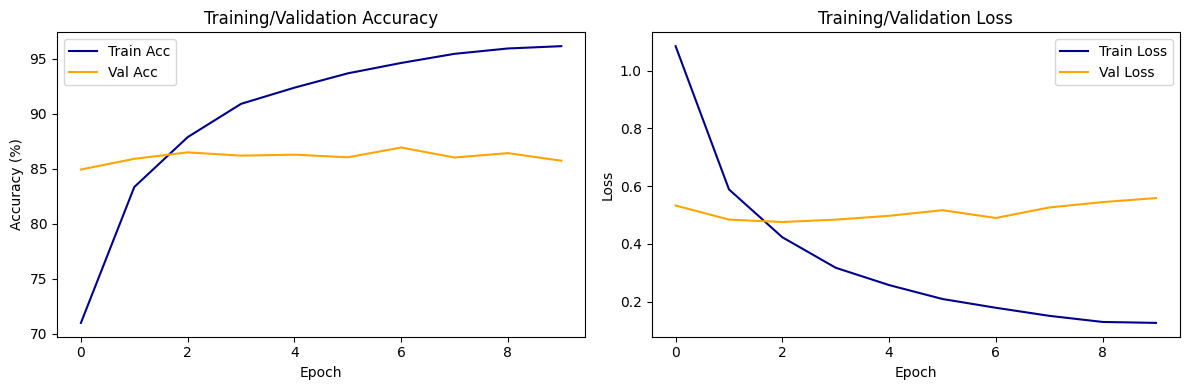

In [ ]:
# -------------------------- Visualization Results --------------------------
# Accuracy & Loss Curves
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Train Acc", color="darkblue")
plt.plot(val_accs, label="Val Acc", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training/Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss", color="darkblue")
plt.plot(val_losses, label="Val Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training/Validation Loss")
plt.tight_layout()
plt.show()

Confusion Matrix Shape: (10, 10)


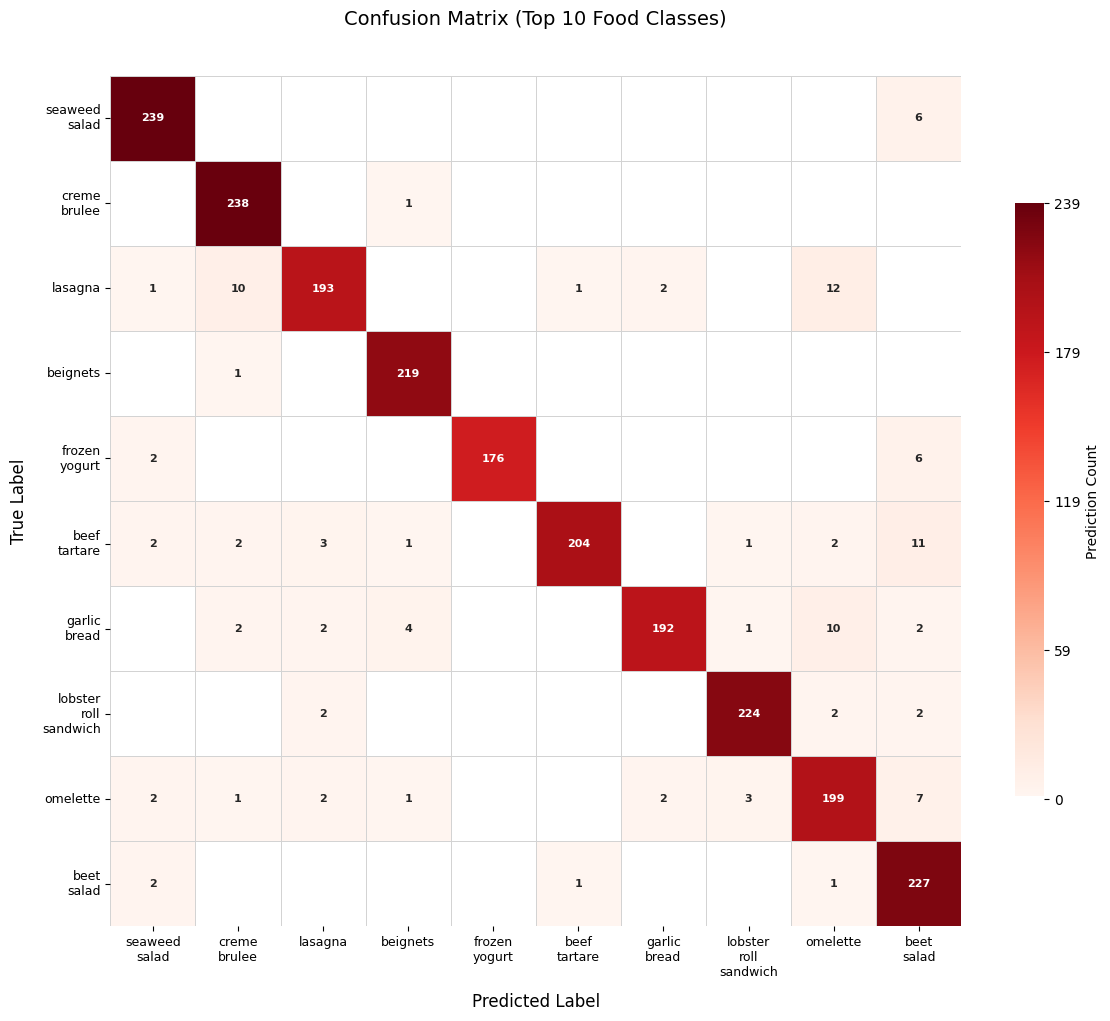

In [ ]:
# -------------------------- Confusion Matrix --------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Keep only top 10 classes
top10_classes = subset_class_names[:10]
top10_idx = [subset_class_names.index(c) for c in top10_classes]  # Original indices
top10_set = set(top10_idx)  # Convert to set for fast lookup

# Filter both true labels and predictions to keep only samples where both belong to top 10 classes
all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)

# Double filter: True label ∈ top 10 classes AND Predicted label ∈ top 10 classes
filter_mask = np.logical_and(
    np.isin(all_labels_np, top10_idx),
    np.isin(all_preds_np, top10_idx)
)

# Filtered data
filtered_preds = all_preds_np[filter_mask]
filtered_labels = all_labels_np[filter_mask]

# Create mapping from original indices to new indices (0-9)
idx_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(top10_idx)}

# Safe mapping function
def safe_map(idx):
    return idx_mapping.get(idx, -1)  # Return -1 if index not found

mapped_labels = np.array([safe_map(idx) for idx in filtered_labels])
mapped_preds = np.array([safe_map(idx) for idx in filtered_preds])

# Filter out -1 from extreme cases
final_mask = np.logical_and(mapped_labels != -1, mapped_preds != -1)
mapped_labels = mapped_labels[final_mask]
mapped_preds = mapped_preds[final_mask]

# Calculate strict 10*10 confusion matrix
cm = confusion_matrix(mapped_labels, mapped_preds)
print(f"Confusion Matrix Shape: {cm.shape}")  # Verification

# Visualization
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    annot_kws={"size": 8, "weight": "bold"},
    xticklabels=[cls.replace("_", "\n") for cls in top10_classes],
    yticklabels=[cls.replace("_", "\n") for cls in top10_classes],
    cbar_kws={"shrink": 0.7, "label": "Prediction Count"},
    mask=cm == 0,  # Hide zero values
    square=True,
    linewidths=0.5,
    linecolor="lightgray"
)

# Adjust labels and title
plt.xticks(rotation=0, fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)
plt.title("Confusion Matrix (Top 10 Food Classes)", fontsize=14, y=1.05)

# Colorbar tick segmentation
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.linspace(0, cm.max(), 5))
cbar.set_ticklabels([f"{int(tick)}" for tick in cbar.get_ticks()])

plt.tight_layout()
plt.show()

In [ ]:
# -------------------------- Explanation Generation Function --------------------------
def generate_explanation(class_name):
    """Generate structured description"""
    attrs = ATTRIBUTE_SHEET[class_name]
    ingredients = ", ".join(attrs["primary_ingredients"])
    method = attrs["cooking_method"]
    flavor = attrs["flavor_profile"]
    return f"A {method} dish made with {ingredients} and {flavor}, offering a rich taste."

# -------------------------- Grad-CAM Visualization Function (Final Stable Version) --------------------------
def grad_cam_visualize(model, image_path, class_idx, output_path):
    """Generate heatmap (adapted to latest pytorch_grad_cam + scalar loss differentiation)"""
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    rgb_img = np.array(image) / 255.0  # Keep original image size
    input_tensor = val_transform(image).unsqueeze(0).to(DEVICE)

    # Select the last convolutional layer of ResNet50 (target_layers is a list)
    target_layers = [model.layer4[-1]]

    # Initialize GradCAM (remove use_cuda parameter)
    cam = GradCAM(model=model, target_layers=target_layers)

    # Generate heatmap: ensure scalar return (key fix!)
    def target_func(output):
        # Return a single scalar regardless of output dimension (target class score of first sample in batch)
        if output.dim() == 1:
            # 1D output: take value of first sample (scalar)
            return output[0]  # Key: return scalar instead of vector
        elif output.dim() == 2:
            # 2D output: take target class score of first sample (scalar)
            return output[0, class_idx]  # Key: return scalar instead of vector
        else:
            raise ValueError(f"Unsupported model output dimension: {output.dim()}")

    grayscale_cam = cam(
        input_tensor=input_tensor,
        targets=[target_func],  # Wrap target function in list
        eigen_smooth=False  # Disable eigen_smooth (reduce complexity, avoid additional errors)
    )
    grayscale_cam = grayscale_cam[0, :]  # Remove batch dimension

    # Ensure heatmap size matches original image
    from PIL import Image as PILImage
    grayscale_cam_resized = PILImage.fromarray((grayscale_cam * 255).astype(np.uint8))
    # Note: resize parameter is (width, height), while rgb_img.shape is (height, width, channels)
    grayscale_cam_resized = grayscale_cam_resized.resize(
        (rgb_img.shape[1], rgb_img.shape[0]),  # Correct size order
        PILImage.LANCZOS
    )
    grayscale_cam = np.array(grayscale_cam_resized) / 255.0

    # Generate visualization result
    visualization = show_cam_on_image(
        rgb_img,
        grayscale_cam,
        use_rgb=True,
        image_weight=0.7
    )

    # Save and display
    plt.imsave(output_path, visualization)
    img = Image.open(output_path)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Grad-CAM Visualization - {subset_class_names[class_idx]}")
    plt.show()

# -------------------------- End-to-End Prediction Function --------------------------
def foodvision_plus_predict(image_path):
    """Input image path, output prediction + explanation + heatmap"""
    # Preprocess image
    image = Image.open(image_path).convert("RGB")
    input_tensor = val_transform(image).unsqueeze(0).to(DEVICE)

    # Prediction: ensure correct class index (adapt to multi-class scenario)
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        # Force adapt to multi-class logic (food-101 is multi-class task, output should be 2D: batch×num_classes)
        if outputs.dim() == 1:
            # If output is 1D, model's final layer may be incorrect (temporary handling, suggest checking model structure)
            print("Warning: Model output is 1D, which may be a model structure error!")
            pred_idx = torch.tensor(0)  # Temporarily take class 0
        else:
            _, pred_idx = torch.max(outputs, 1)
        pred_class = subset_class_names[pred_idx.item()]

    # Generate explanation
    explanation = generate_explanation(pred_class)

    # Generate heatmap
    grad_cam_output = f"/content/grad_cam_{pred_class}.png"
    grad_cam_visualize(model, image_path, pred_idx.item(), grad_cam_output)

    # Output results
    print("===== Prediction Results =====")
    print(f"Dish Name: {pred_class}")
    print(f"Primary Ingredients: {', '.join(ATTRIBUTE_SHEET[pred_class]['primary_ingredients'])}")
    print(f"Cooking Method: {ATTRIBUTE_SHEET[pred_class]['cooking_method']}")
    print(f"Flavor Profile: {ATTRIBUTE_SHEET[pred_class]['flavor_profile']}")
    print(f"Structured Description: {explanation}")

Random Test Image Path: /content/drive/MyDrive/datasets/food-101/images/baby_back_ribs/3774954.jpg


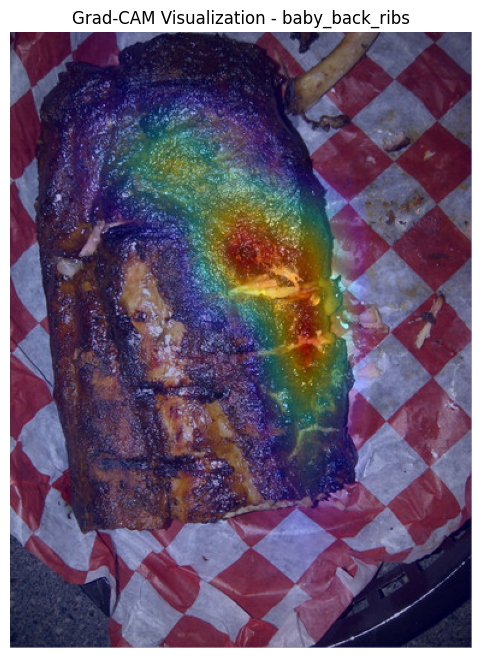

===== Prediction Results =====
Dish Name: baby_back_ribs
Primary Ingredients: pork ribs, bbq sauce, spices, brown sugar
Cooking Method: grilled, roasted, braised
Flavor Profile: savory, smoky, tangy
Structured Description: A grilled, roasted, braised dish made with pork ribs, bbq sauce, spices, brown sugar and savory, smoky, tangy, offering a rich taste.


In [ ]:
import random

# -------------------------- Test Prediction --------------------------
# Method 1: Test with random image from training set (random selection)
random_idx = random.randint(0, len(train_dataset.image_paths) - 1)  # Generate random index (0 to dataset length - 1)
test_image_path = train_dataset.image_paths[random_idx]  # Select random image path from training set
print(f"Random Test Image Path: {test_image_path}")  # Print path of the randomly selected image

# Method 2: Manually upload image (uncomment to execute)
# from google.colab import files
# uploaded = files.upload()
# test_image_path = list(uploaded.keys())[0]

# Execute prediction
foodvision_plus_predict(test_image_path)